In [1]:
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from pathlib import Path
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from IPython.display import Markdown
from utils import plot_confusion_matrix, mosaic
plt.rcParams['font.size']=20
plt.rcParams['figure.figsize']=(10,6)

# Aprendizaje Supervisado
## Clasificación del tipo de pokemon según su imagen

Querémos ver si es posible predecir el tipo de pokemon según el contenido de su imágen

### Carga de Datos

In [2]:
# Cargar la tabla de los stats
df = pd.read_csv("datasets/pokemon_imagenes.csv")

In [3]:
# Cargar las imágnes en el orden que están en el dataframe
imgs = []
for img_id in df['img_id']:
    img = plt.imread('datasets/pokemon-images/{}.png'.format(img_id))
    imgs.append(img)
    
imgs = np.array(imgs)
imgs.shape

(800, 256, 256, 4)

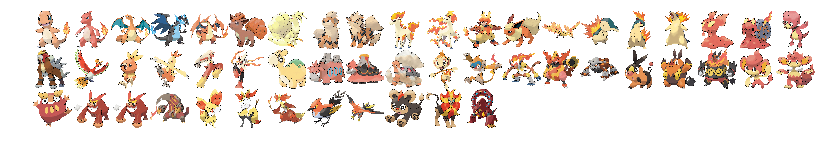

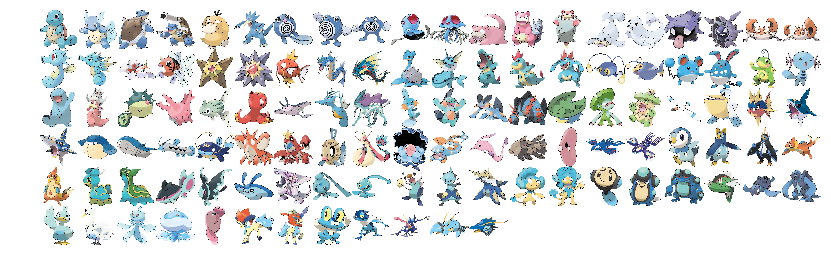

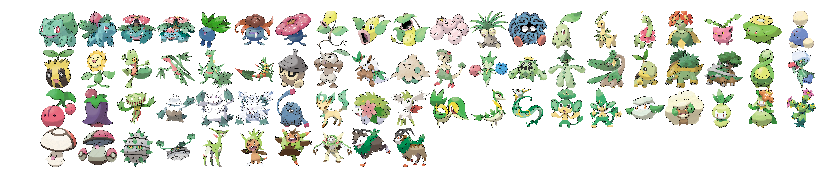

In [4]:
lista = df[df['Type 1']=='Fire'].index
plt.figure(figsize=(14,14))
plt.imshow(mosaic(imgs[lista],20))
plt.axis('off');

lista = df[df['Type 1']=='Water'].index
plt.figure(figsize=(14,14))
plt.imshow(mosaic(imgs[lista],20))
plt.axis('off');

lista = df[df['Type 1']=='Grass'].index
plt.figure(figsize=(14,14))
plt.imshow(mosaic(imgs[lista],20))
plt.axis('off');

### Preliminares

Cuantos tipos de pokemon hay? Cuantas muestras por tipo?

#### Tipos de pokemon: 18

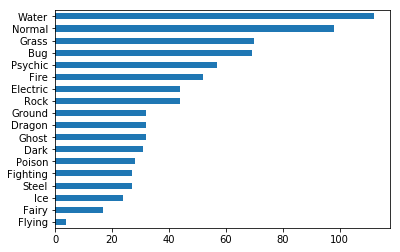

In [5]:
n_tipos = len(df['Type 1'].unique())
display(Markdown('#### Tipos de pokemon: {}'.format(n_tipos)))
df['Type 1'].value_counts(ascending=True).plot.barh();

Qué implicancia tiene que haya más muestras de un tipo que de otro?

In [6]:
clase_mayoritaria = df['Type 1'].value_counts(ascending=True).index[-1]
n_clase_mayoritaria = df['Type 1'].value_counts(ascending=True).max()

display(Markdown('#### Si elijo siempre {} tengo {:2.0f}% de chances de acertar'.format(clase_mayoritaria, n_clase_mayoritaria/len(df)*100)))

#### Si elijo siempre Water tengo 14% de chances de acertar

### Extracción de atributos (features)

Qué atributos necesitamos para poder mapear las imágenes al tipo de pokemon. Contar la frecuencia de colores suena razonable

In [7]:
# Computar histogramas de colores
histograms = []
for img in imgs:
    values = []
    for i in range(3):
        values_, bins = np.histogram(img[:,:,i].flatten(),20)
        # quitamos el primer valor [1:] ya que hay muchos pixeles negros y mejora los resultados (prueba y error)
        values.append(values_[1:])
    histograms.append( np.hstack(values) )
histograms = np.array(histograms)
histograms.shape

(800, 57)

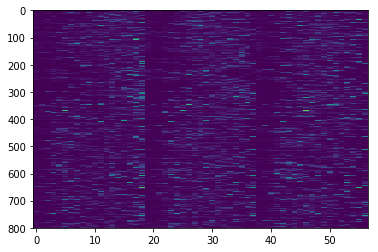

In [8]:
# lista = df[df['Type 1']=='Fire'].index
plt.imshow(histograms,aspect='auto')

### Separar los datos en train y test

In [9]:
from sklearn.model_selection import train_test_split

X = histograms[:,1:]
y = df['Type 1']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

display(X_train.shape)
display(X_test.shape)

(536, 56)

(264, 56)

### Entrenar y predecir  un modelo de clasificación

Vamos a usar una tipo de modelo que se llama Random Forest

In [10]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
   
# Definición
clf = RandomForestClassifier(max_features=20, class_weight='balanced',n_estimators=1000, random_state=50)

# Entrenamiento con el conjunto de datos _train
clf.fit(X_train, y_train) 

# Prediccioń de los datos de test
y_pred = clf.predict(X_test)

### Performance en el Test set
#### Accuracy 

El accuracy representa cuantas prediciones correctas hubo sobre el total

In [11]:
# computar el accuracy con el ground truth (test) y las predicciones
acc = accuracy_score(y_test,y_pred)
display(Markdown('#### Accuracy {:2.2f}%'.format(acc*100)))

#### Accuracy 30.30%

#### Matriz de confusión

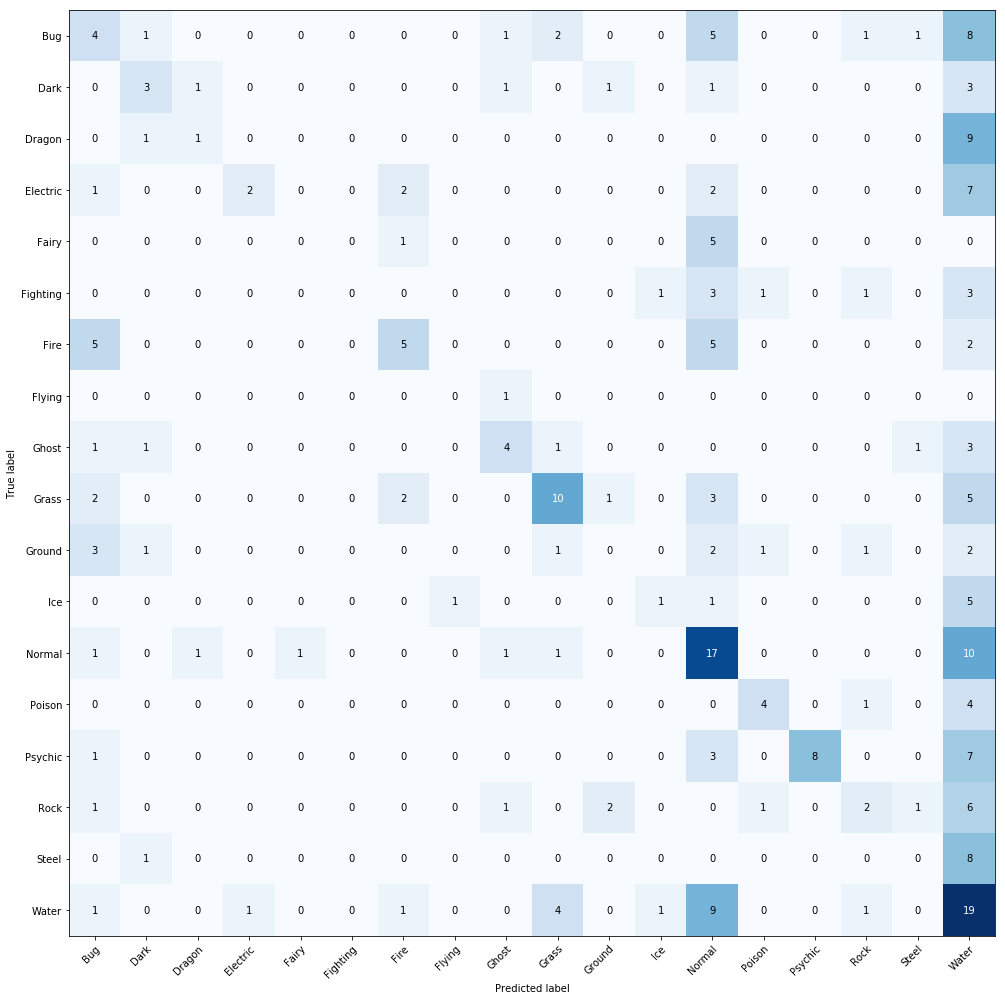

In [12]:
plt.figure(figsize=(14,14))
plot_confusion_matrix(y_test,y_pred,classes=clf.classes_);

#### Métricas Precisión y Recall

In [13]:
print(classification_report(y_test,y_pred,labels=clf.classes_))

              precision    recall  f1-score   support

         Bug       0.20      0.17      0.19        23
        Dark       0.38      0.30      0.33        10
      Dragon       0.33      0.09      0.14        11
    Electric       0.67      0.14      0.24        14
       Fairy       0.00      0.00      0.00         6
    Fighting       0.00      0.00      0.00         9
        Fire       0.45      0.29      0.36        17
      Flying       0.00      0.00      0.00         1
       Ghost       0.44      0.36      0.40        11
       Grass       0.53      0.43      0.48        23
      Ground       0.00      0.00      0.00        11
         Ice       0.33      0.12      0.18         8
      Normal       0.30      0.53      0.39        32
      Poison       0.57      0.44      0.50         9
     Psychic       1.00      0.42      0.59        19
        Rock       0.29      0.14      0.19        14
       Steel       0.00      0.00      0.00         9
       Water       0.19    

/home/miles/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Performance en train set

#### Accuracy 100.00%

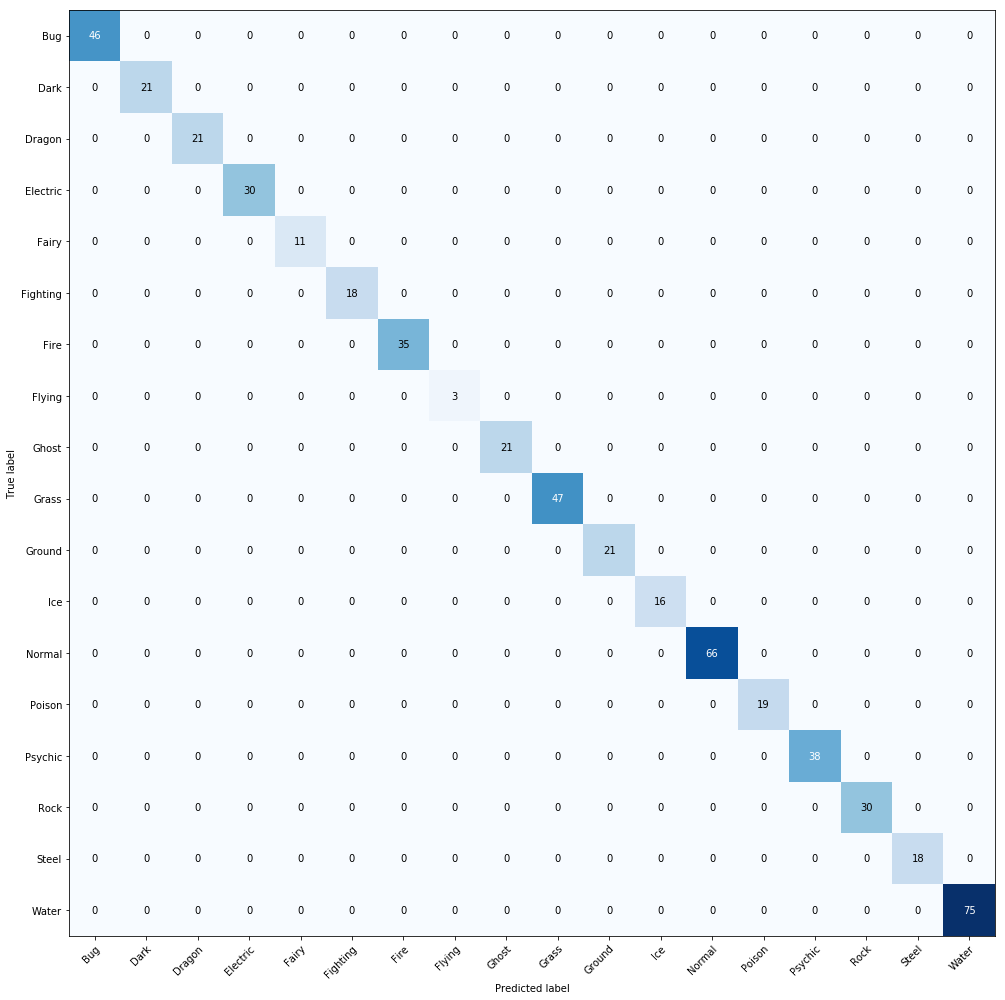

In [14]:
# computar el accuracy con el ground truth (test) y las predicciones
y_pred = clf.predict(X_train)
acc = accuracy_score(y_train,y_pred)
display(Markdown('#### Accuracy {:2.2f}%'.format(acc*100)))
plt.figure(figsize=(14,14))
plot_confusion_matrix(y_train,y_pred,classes=clf.classes_);

### Overfitting

![texto alternativo](https://cdn-images-1.medium.com/max/1200/1*cdvfzvpkJkUudDEryFtCnA.png)

___
___
___

## Detección de legenderiedad

Ahora vamos ver si podemos entrenar un modelo para detectar si el poquemon es legendario o no

### Preliminares

Desbalance

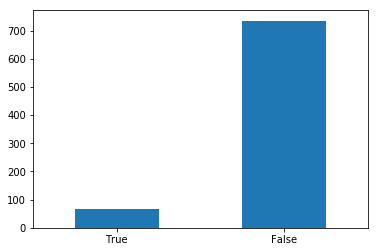

In [15]:
df['Legendary'].value_counts(ascending=True).plot.bar(rot=0);

In [16]:
clase_mayoritaria = df['Legendary'].value_counts(ascending=True).index[-1]
n_clase_mayoritaria = df['Legendary'].value_counts(ascending=True).max()

display(Markdown('#### Si elijo siempre {} tengo {:2.0f}% de chances de acertar'.format(clase_mayoritaria, n_clase_mayoritaria/len(df)*100)))

#### Si elijo siempre False tengo 92% de chances de acertar

### Entrenamiento

En este caso se utiliza un modelo Support Vector Machine (SVM) y se agregan las opciones de GridSearch y de CrossValidation (CV). 
GridSearch permite automatizar la exploración de configuraciones de los parámetros que toma el modelo. En este caso los parámetros 'Kernel' y 'C'.

CrossValidation permite entrenar varios modelos con diferentes splits train y test, dividiendo el conjunto de datos en subconjuntos (_folds_) iguales.


In [17]:
# en sklearn se llama svc al svm
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV

X = df[['HP', 'Attack', 'Defense','Sp. Atk', 'Sp. Def', 'Speed']]
y = df['Legendary']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    
parameters = parameters = {'kernel':('linear', 'rbf'), 'C':np.logspace(-3,2,6)}
clf = GridSearchCV(SVC(gamma="scale", class_weight='balanced'), parameters, cv=3, n_jobs=4, return_train_score=False)
clf.fit(X,y)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=4,
       param_grid={'kernel': ('linear', 'rbf'), 'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
       scoring=None, verbose=0)

### Predicción

Para hacer las predicciones el sistema utiliza el modelo con mejores resultados.

              precision    recall  f1-score   support

       False       1.00      0.97      0.99       248
        True       0.70      1.00      0.82        16

   micro avg       0.97      0.97      0.97       264
   macro avg       0.85      0.99      0.90       264
weighted avg       0.98      0.97      0.98       264



#### Accuracy: 94.0%

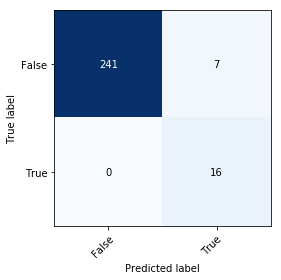

In [18]:
y_pred = clf.predict(X_test)
print(classification_report(y_test,y_pred))
plot_confusion_matrix(y_test,y_pred,classes=clf.classes_)
display(Markdown('#### Accuracy: {}%'.format(clf.best_score_*100)))

### Analisis del modelo

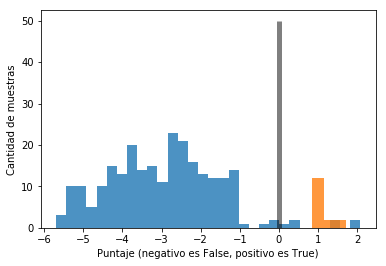

In [19]:
Z = clf.decision_function(X_test)
score_true = Z[y_test]
score_false = Z[~y_test]

values, bins = np.histogram(score_false,30)
plt.bar(bins[:-1],values, np.diff(bins), alpha=0.8)
values, bins = np.histogram(score_true,3)
plt.bar(bins[:-1],values, np.diff(bins), alpha=0.8)
plt.vlines(0,0,50,lw=5, alpha=0.5);
plt.xlabel('Puntaje (negativo es False, positivo es True)')
plt.ylabel('Cantidad de muestras');

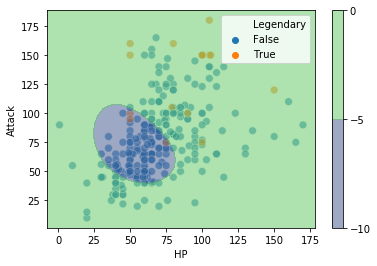

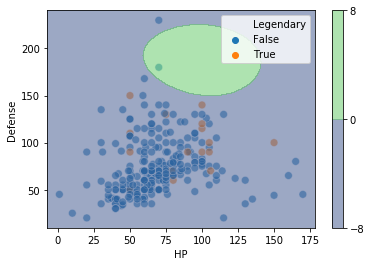

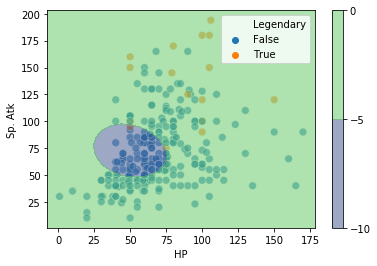

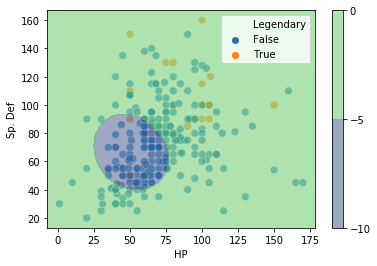

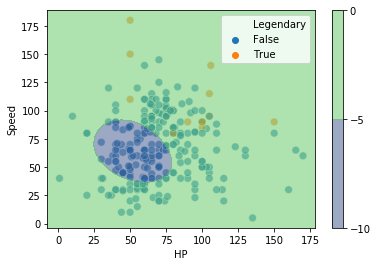

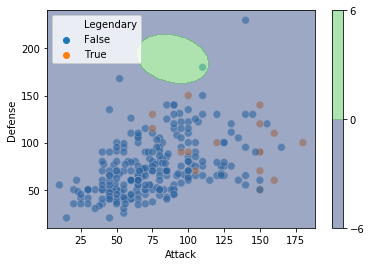

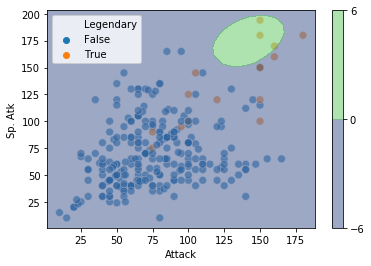

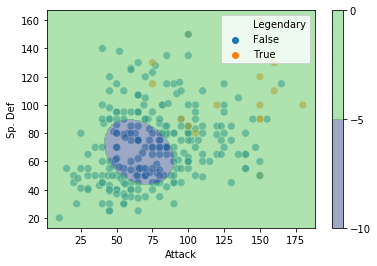

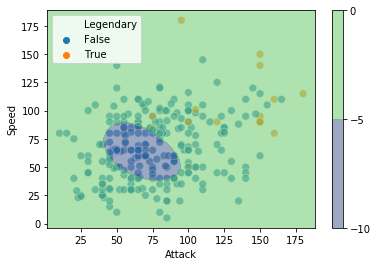

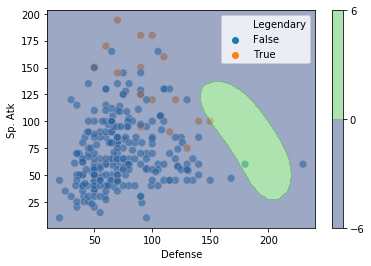

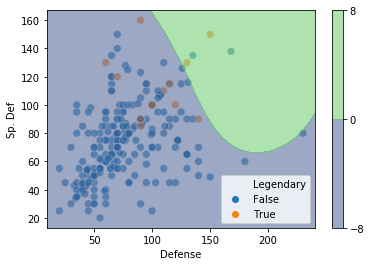

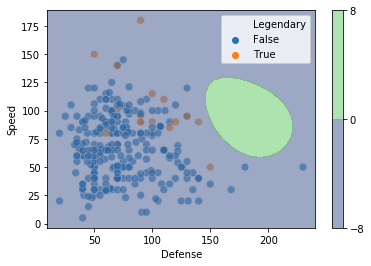

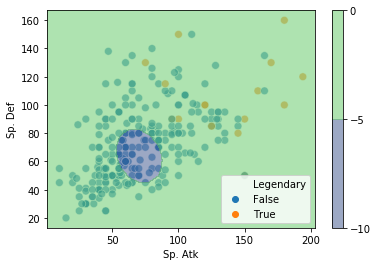

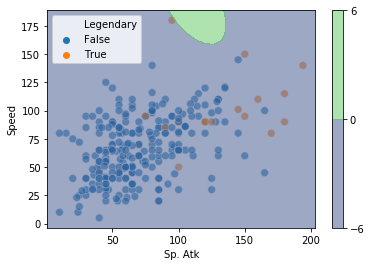

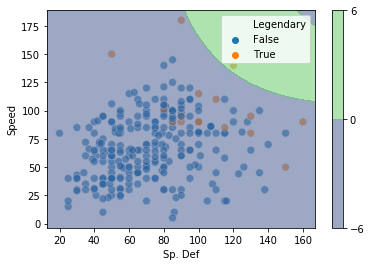

In [20]:
import seaborn as sns
from itertools import combinations

for xname, yname in list(combinations(list(X.columns),2)):
    plt.figure()
    sns.scatterplot(x=xname, y=yname, data=pd.concat([X_test,  y_test], axis=1), hue='Legendary', s=60,alpha=0.6)

    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # create grid to evaluate model
    xx = np.linspace(xlim[0], xlim[1], 30)
    yy = np.linspace(ylim[0], ylim[1], 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    Xmean = np.repeat(X.mean().values,len(XX.ravel())).reshape(X.shape[1],-1).T

    Xmean[:,list(X.columns).index(xname)]=XX.ravel()
    Xmean[:,list(X.columns).index(yname)]=YY.ravel()

    Z = clf.decision_function(Xmean).reshape(XX.shape)
    m = ax.contourf(XX, YY, Z, levels=0, alpha=0.5,
               linestyles=['--', '-', '--'])
    plt.colorbar(m)